In [ ]:
# Install required packages
# !pip install wordcloud
# !pip install tensorflow
# !pip install tensorflow-gpu

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl (7.5 kB)


In [12]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# Load and clean the data
data = pd.read_csv("train.csv")
data = data.dropna() #< drop rows with missing values

# Extract the features (text) and labels (scores)
X = data.iloc[:, 1]
y = data.iloc[:, 2]

print(X.head())
print()
print(y.head())

# Convert y to integer type
y = y.astype(int)
maxScore = y.max()

0    Many people have car where they live. The thin...
1    I am a scientist at NASA that is discussing th...
2    People always wish they had the same technolog...
3    We all heard about Venus, the planet without a...
4    Dear, State Senator\n\nThis is a letter to arg...
Name: full_text, dtype: object

0    3.0
1    3.0
2    4.0
3    4.0
4    3.0
Name: score, dtype: float64


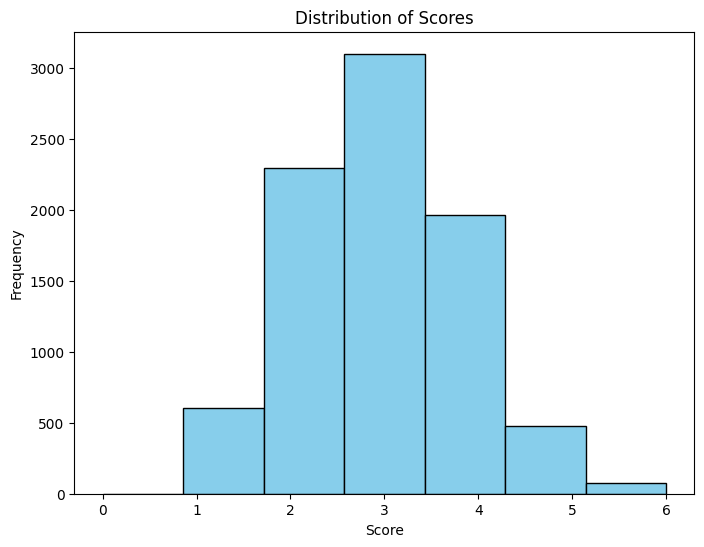

In [4]:
# Visualize distribution of scores
plt.figure(figsize=(8, 6))
plt.hist(y, bins=7, range=(0, y.max()), color='skyblue', edgecolor='black')
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.xticks(range(maxScore + 1))  # Ensure that x-axis shows all scores from 0 to the max score (6)
plt.show()

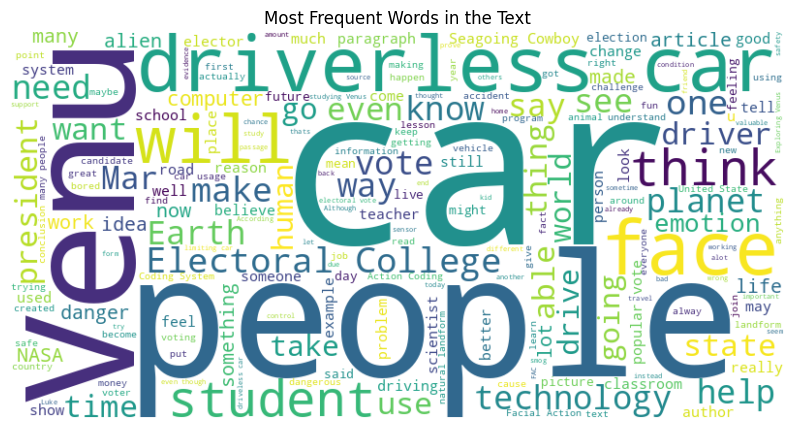

In [5]:
# Visualize the most frequent words
text_data = ' '.join(X)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in the Text")
plt.show()

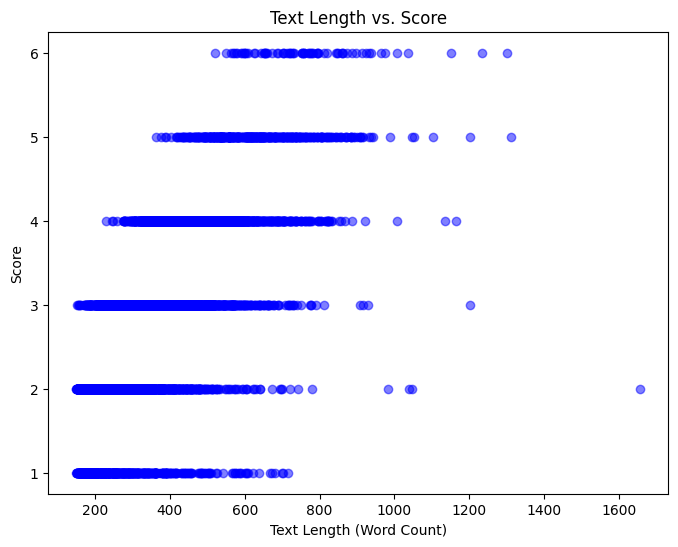

In [6]:
# Visualize length of text vs. score
# Calculate the length of each text (in terms of word count)
text_lengths = X.apply(lambda text: len(text.split()))

# Plot the length of text vs. the score
plt.figure(figsize=(8, 6))
plt.scatter(text_lengths, y, alpha=0.5, color='blue')
plt.title("Text Length vs. Score")
plt.xlabel("Text Length (Word Count)")
plt.ylabel("Score")
plt.show()

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
# Text preprocessing (tokenization & padding)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  # Fit tokenizer only on the training data

# Convert texts to sequences (tokenized words)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences to ensure uniform input size
# maxlength = 50  #< Maximum length of input sequences
X_train_pad = pad_sequences(X_train_seq)
X_test_pad = pad_sequences(X_test_seq)

# Convert scores (labels) into numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

In [9]:
# Build the LSTM Model
model = Sequential()

# Embedding Layer: To convert tokens into dense vectors (word embeddings)
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,  #< vocabulary size
                    output_dim=128)) #< embedding dimension

# LSTM Layer: To process sequences and capture dependencies
model.add(LSTM(64, return_sequences=False))  #< LSTM with 64 units

# Dropout Layer: To prevent overfitting
model.add(Dropout(0.5))

# Dense Layer: To output a probability distribution across possible classes (0-6)
model.add(Dense(maxScore+1, activation='softmax'))

In [10]:
# Compile the model
# Use sparse categorical cross-entropy for multi-class classification
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9595 - loss: 0.1512 - val_accuracy: 0.3791 - val_loss: 2.2817 - learning_rate: 0.0010
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.9527 - loss: 0.1553 - val_accuracy: 0.4158 - val_loss: 2.5147 - learning_rate: 0.0010
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.9790 - loss: 0.0898 - val_accuracy: 0.4244 - val_loss: 2.6566 - learning_rate: 0.0010
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.9777 - loss: 0.0831 - val_accuracy: 0.4336 - val_loss: 2.5474 - learning_rate: 0.0010
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.9776 - loss: 0.0808 - val_accuracy: 0.4044 - val_loss: 2.7720 - learning_rate: 0.0010
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.9794 - loss: 0.0802 - val_accuracy: 0.4172 - val_loss: 2.5987 - learning_rate: 0.0010
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 170ms/step - accuracy: 0.9886 - loss: 0.

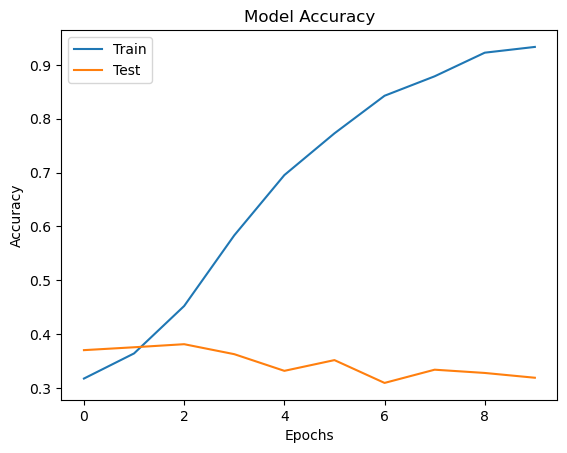

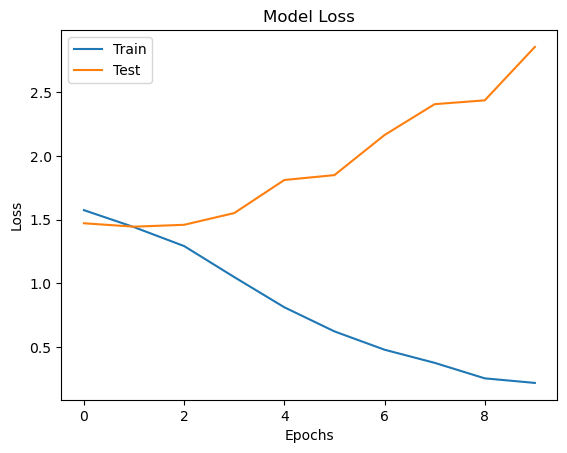

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
'''
As displayed above, the model's training accuracy is improving signifcantly,
but the validation accuracy is lagging, which could indicate overfitting.
Therefore, further iterative improvements are included below to address this.
'''

"\nAs displayed above, the model's training accuracy is improving signifcantly, but the validation accuracy is lagging, which could indicate overfitting. Therefore, further iterative improvements are included below to address this.\n"

In [15]:
'''
Learning Rate Scheduling:
Dynamically adjusting the learning rate can help the model converge more effectively.
For instance, using a learning rate scheduler can help reduce the learning rate as the training progresses.
'''
# Train the model
def scheduler(epoch, lr):
    if epoch > 3:
        return lr * 0.1  #< Decay after 3 epochs
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64,
                    validation_data=(X_test_pad, y_test),
                    callbacks=[lr_scheduler])

SyntaxError: incomplete input (<ipython-input-15-0ee31eebd46a>, line 1)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()